In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

## 1. Load data

In [2]:
results_path = "/home/obola/repositories/cicero-scm-surrogate/data/20250805_152136/raw/results.pkl"
scenario_path = "/home/obola/repositories/cicero-scm-surrogate/data/20250805_152136/raw/scenarios.pkl"

results = pickle.load(open(results_path, "rb"))
scenarios = pickle.load(open(scenario_path, "rb"))
baseline_result = pd.read_csv("baseline_result.csv", index_col="Unnamed: 0")

In [5]:
scenarios[0]['emissions_data']

,CO2_FF,CO2_AFOLU,CH4,N2O,SO2,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,...,CF4,SF6,NOx,CO,NMVOC,NH3,BMB_AEROS_BC,BMB_AEROS_OC,BC,OC
Component,,,,,,,,,,,,,,,,,,,,,
1900,0.487860,0.730130,87.613288,0.862520,11.353712,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.028558,0.000000,5.081585,459.544467,71.906566,13.276670,1.376890,12.919620,1.984931,6.831168
1901,0.504180,0.796424,88.391167,0.870750,11.780428,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.047784,0.000000,5.194392,457.616831,71.632632,13.301410,1.374407,12.625578,2.008546,6.862045
1902,0.519031,0.799794,89.262825,0.880552,12.105864,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.050743,0.000000,5.171970,455.026177,71.241498,13.412488,1.348448,12.461322,2.033094,6.896739
1903,0.566112,0.829069,89.890741,0.889990,13.049888,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.055920,0.000000,5.182370,449.962530,70.253764,13.437521,1.307226,12.080061,2.082160,6.950537
1904,0.574804,0.855582,91.356749,0.900320,13.280268,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.068492,0.000000,5.392180,462.621765,72.884376,13.731472,1.363804,12.655512,2.100254,7.000607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,12.783395,0.281406,628.210287,7.622239,29.615287,11.670803,0.087628,0.011030,0.043255,0.527377,...,9.502669,2.765876,37.152747,750.307784,197.090170,76.127194,1.353848,12.511863,5.519927,15.628515
2047,12.342149,0.238016,609.238668,7.660101,28.996443,11.103645,0.072777,0.009443,0.037923,0.508170,...,9.470428,2.698624,36.934343,740.760317,196.791517,75.993239,1.341883,12.520044,5.448367,15.460842
2048,12.641297,0.190594,607.314359,7.729788,28.457737,10.611415,0.058502,0.007831,0.032558,0.489780,...,9.426404,2.652436,36.404693,732.870126,195.292162,76.418190,1.342790,12.516055,5.344380,15.153639


In [28]:
baseline_result

,climate_model,model,run_id,scenario,region,variable,unit,1900,1901,1902,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,CICERO-SCM-PY,ssp245,13555_old_NR_improved,ssp245,World,Surface Air Temperature Change,K,-0.005126,-0.012631,-0.015937,...,1.412663,1.428602,1.444106,1.459105,1.473571,1.487491,1.500863,1.513691,1.525979,1.537739


In [19]:
results

,climate_model,model,run_id,scenario,region,variable,unit,1900,1901,1902,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,CICERO-SCM-PY,rw_growth±5pct_000,13555_old_NR_improved,rw_growth±5pct_000,World,Surface Air Temperature Change,K,-0.005126,-0.012631,-0.015937,...,1.647743,1.6814,1.716387,1.750455,1.783003,1.815636,1.848353,1.879568,1.909653,1.939917
0,CICERO-SCM-PY,rw_growth±5pct_001,13555_old_NR_improved,rw_growth±5pct_001,World,Surface Air Temperature Change,K,-0.005126,-0.012631,-0.015937,...,1.470678,1.483728,1.495999,1.50871,1.522143,1.534804,1.547871,1.561875,1.574615,1.586264
0,CICERO-SCM-PY,rw_growth±5pct_002,13555_old_NR_improved,rw_growth±5pct_002,World,Surface Air Temperature Change,K,-0.005126,-0.012631,-0.015937,...,1.391098,1.396922,1.401661,1.406054,1.409659,1.411594,1.413498,1.417293,1.421812,1.424385
0,CICERO-SCM-PY,rw_growth±5pct_003,13555_old_NR_improved,rw_growth±5pct_003,World,Surface Air Temperature Change,K,-0.005126,-0.012631,-0.015937,...,1.332502,1.345988,1.359537,1.372423,1.383793,1.394771,1.405803,1.416323,1.425937,1.434329
0,CICERO-SCM-PY,rw_growth±5pct_004,13555_old_NR_improved,rw_growth±5pct_004,World,Surface Air Temperature Change,K,-0.005126,-0.012631,-0.015937,...,1.449544,1.470715,1.491597,1.511218,1.530707,1.55073,1.570702,1.590479,1.609013,1.62758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,CICERO-SCM-PY,rw_growth±5pct_9995,13555_old_NR_improved,rw_growth±5pct_9995,World,Surface Air Temperature Change,K,-0.005126,-0.012631,-0.015937,...,1.500659,1.519394,1.537121,1.554786,1.571643,1.587586,1.602624,1.615774,1.627294,1.638351
0,CICERO-SCM-PY,rw_growth±5pct_9996,13555_old_NR_improved,rw_growth±5pct_9996,World,Surface Air Temperature Change,K,-0.005126,-0.012631,-0.015937,...,1.212045,1.216217,1.218672,1.219979,1.220014,1.220103,1.219226,1.218251,1.216661,1.212699
0,CICERO-SCM-PY,rw_growth±5pct_9997,13555_old_NR_improved,rw_growth±5pct_9997,World,Surface Air Temperature Change,K,-0.005126,-0.012631,-0.015937,...,1.215819,1.228443,1.239922,1.248618,1.25673,1.264359,1.271076,1.275373,1.279378,1.284254
0,CICERO-SCM-PY,rw_growth±5pct_9998,13555_old_NR_improved,rw_growth±5pct_9998,World,Surface Air Temperature Change,K,-0.005126,-0.012631,-0.015937,...,1.211532,1.221116,1.228483,1.23489,1.2409,1.245917,1.249827,1.253213,1.256011,1.257938


## 2. Plot the temperature curves

In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_temperature_ensemble(results, baseline_result, start_year=2000, n_sample=80, save_name=None):
    """
    Plot baseline temperature trajectory with scenario ensemble (5–95% band + spaghetti).
    Robust to year columns being str or int.
    """
    var_name = "Surface Air Temperature Change"

    # Identify all year columns (as ints), sorted
    def _all_years(df):
        ys = []
        for c in df.columns:
            if isinstance(c, (int, np.integer)):
                ys.append(int(c))
            elif isinstance(c, str) and c.isdigit():
                ys.append(int(c))
        return sorted(set(ys))

    # Extract a 1D numpy array from a DataFrame/Series row for the given years,
    # accepting either int or str column labels.
    def _row_year_values(row_like, years_int):
        idx = row_like.index
        cols = []
        for y in years_int:
            if y in idx:
                cols.append(y)
            elif str(y) in idx:
                cols.append(str(y))
            else:
                # year column missing: skip or raise; here we raise for clarity
                raise KeyError(f"Year {y} not found in columns (int or str).")
        return row_like[cols].to_numpy(dtype=float)

    # 1) Filter variable
    df_temp = results[results["variable"] == var_name].copy()
    if df_temp.empty:
        raise ValueError(f"`results` has no rows with variable == '{var_name}'.")

    years_all = _all_years(df_temp)
    years_mask = np.array(years_all) >= start_year
    years = np.array(years_all)[years_mask]

    # 2) Baseline series
    base = baseline_result[baseline_result["variable"] == var_name]
    if base.empty:
        raise ValueError(f"`baseline_result` has no rows with variable == '{var_name}'.")
    unit = str(base["unit"].iloc[0]) if "unit" in base.columns else "K"
    base_row = base.iloc[0]
    baseline_series = _row_year_values(base_row, years_all)[years_mask]

    # 3) Stack scenarios into matrix (T x S)
    vals = []
    for _, row in df_temp.iterrows():
        v = _row_year_values(row, years_all)
        vals.append(v)
    M_full = np.stack(vals, axis=1)     # shape: (T_all, S)
    M = M_full[years_mask, :]           # keep >= start_year

    # 4) Percentiles + sample subset
    q5, q95 = np.percentile(M, [5, 95], axis=1)
    S = M.shape[1]
    rng = np.random.default_rng(0)
    samp = np.arange(S) if S <= n_sample else rng.choice(S, size=n_sample, replace=False)

    # 5) Plot (style matched to emissions figures)
    plt.figure(figsize=(12, 6))
    plt.plot(years, M[:, samp], color="#999999", lw=0.8, alpha=0.20, zorder=1)     # spaghetti
    plt.fill_between(years, q5, q95, color="#a6cee3", alpha=0.35, label="5–95% interval", zorder=2)
    plt.plot(years, baseline_series, color="#1f78b4", lw=2.2, label="Baseline temperature change", zorder=3)
    if start_year <= 2015 <= years.max():
        plt.axvline(2015, color="red", lw=1, ls="--", label="Start year")

    plt.xlabel("Year")
    plt.ylabel(f"Surface air temperature change ({unit})")
    plt.legend(frameon=True, loc="upper left")
    plt.tight_layout()

    if save_name:
        os.makedirs("plots", exist_ok=True)
        plt.savefig(os.path.join("plots", save_name), dpi=300, bbox_inches="tight")
    plt.show()

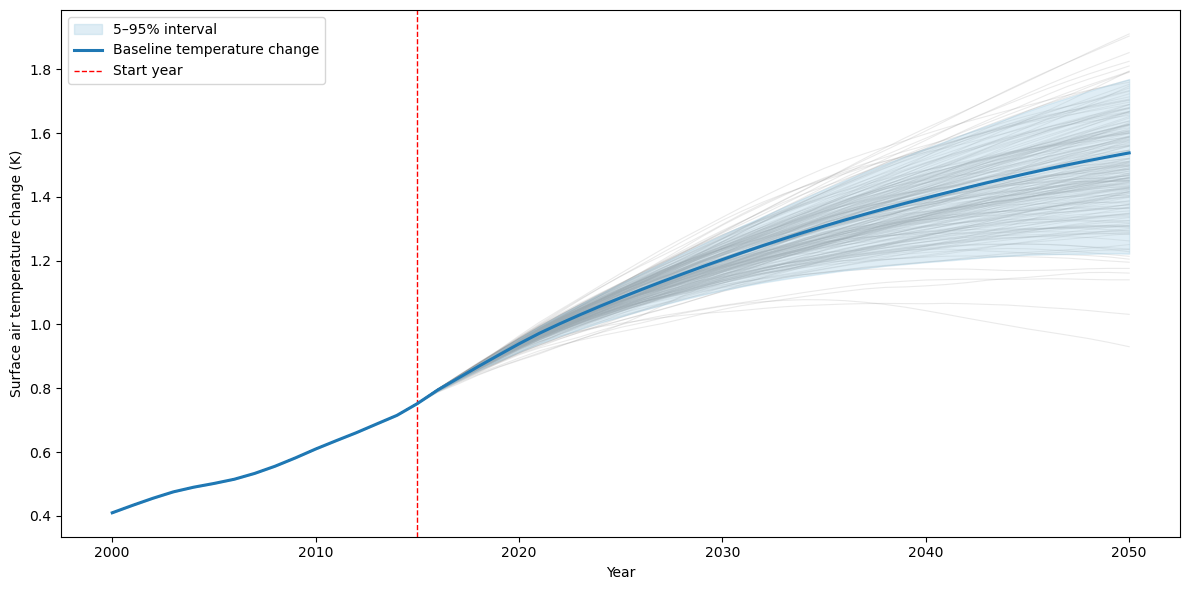

In [39]:
plot_temperature_ensemble(results, baseline_result, start_year=2000, n_sample=200, save_name="temperature_ensemble.pdf")

## 3. Plot the emission policies

In [5]:
import sys
import os
sys.path.insert(0,os.path.join(os.getcwd(), '../ciceroscm/', 'src'))

from ciceroscm import CICEROSCM
from ciceroscm.parallel.cscmparwrapper import run_ciceroscm_parallel
import ciceroscm.input_handler as input_handler

test_data_dir = "/home/obola/repositories/cicero-scm-surrogate/ciceroscm/tests/test-data"
em_data_start = 1900
em_data_policy = 2015
em_data_end = 2050

ih = input_handler.InputHandler({"nyend": em_data_end, "nystart": em_data_start, "emstart": em_data_policy})
em_data = ih.read_emissions(os.path.join(test_data_dir, "ssp245_em_RCMIP.txt"))

/home/obola/repositories/cicero-scm-surrogate/notebooks/../ciceroscm/src/ciceroscm/parallel/_parallel_process.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:


def plot_emission_ensemble(em_data, scenarios, gas, start_year=2000, n_sample=80, show_band=True, save_name=None):
    """
    Plot baseline trajectory (em_data[gas]) together with scenario trajectories.
    """
    mask = em_data.index >= start_year
    years = em_data.index[mask].to_numpy()
    baseline = em_data.loc[mask, gas].to_numpy()

    # Stack scenario series: shape T x S
    series = [scen["emissions_data"].loc[mask, gas].to_numpy() for scen in scenarios]
    M = np.stack(series, axis=1)

    # Percentiles for fan band
    if show_band:
        q5, q95 = np.percentile(M, [5, 95], axis=1)

    # Sample a subset for spaghetti
    S = M.shape[1]
    rng = np.random.default_rng(0)
    samp = np.arange(S) if S <= n_sample else rng.choice(S, size=n_sample, replace=False)

    # --- Plot ---
    plt.figure(figsize=(6, 3))
    # Scenario lines (light gray)
    plt.plot(years, M[:, samp], color="#999999", linewidth=0.8, alpha=0.15)
    # Percentile band (soft blue)
    if show_band:
        plt.fill_between(years, q5, q95, color="#a6cee3", alpha=0.35, label="5–95% interval")
    # Baseline (strong blue)
    plt.plot(years, baseline, color="#1f78b4", linewidth=2.2, label="Baseline")

    plt.xlabel("Year")
    plt.ylabel(f"{gas} emissions (Mt/yr)")
   # plt.title(f"{gas} — Baseline and scenario ensemble")
    plt.legend(frameon=True, loc="upper right", bbox_to_anchor=(1, 1), fontsize = 9)    
    plt.tight_layout()

    if save_name:
        os.makedirs("plots", exist_ok=True)
        save_path = os.path.join("plots", save_name)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

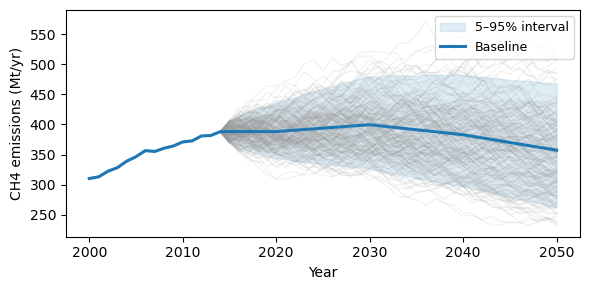

In [57]:
plot_emission_ensemble(em_data, scenarios, gas="CH4", n_sample=200, save_name="CH4_ensemble.pdf")

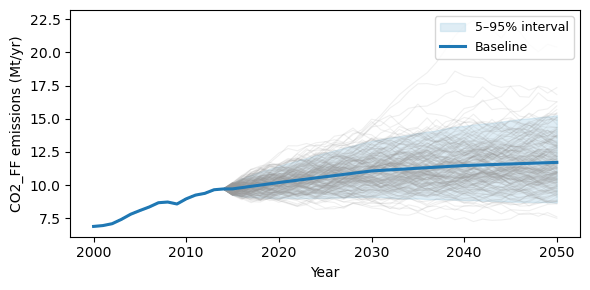

In [58]:
plot_emission_ensemble(em_data, scenarios, gas="CO2_FF", n_sample=200, save_name="CO2_FF_ensemble.pdf")

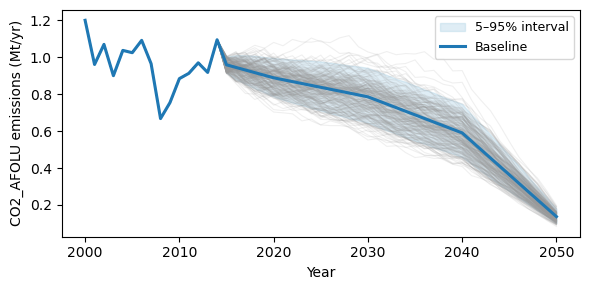

In [59]:
plot_emission_ensemble(em_data, scenarios, gas="CO2_AFOLU", n_sample=200, save_name="CO2_AFOLU_ensemble.pdf")

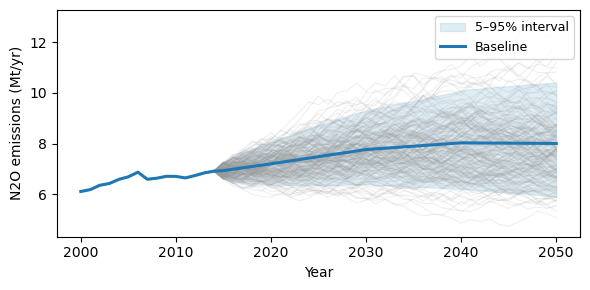

In [60]:
plot_emission_ensemble(em_data, scenarios, gas="N2O", n_sample=200, save_name="N2O_ensemble.pdf")

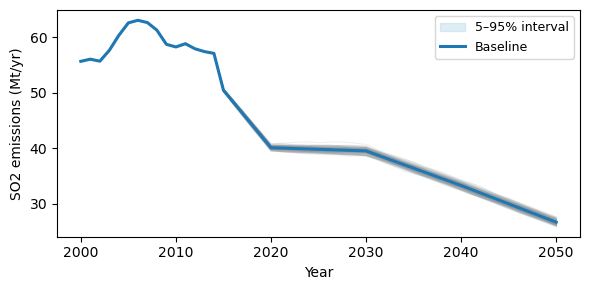

In [73]:
plot_emission_ensemble(em_data, scenarios, gas="SO2", n_sample=100, save_name="SO2_ensemble.pdf")

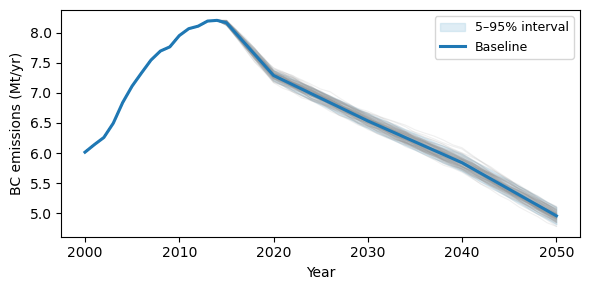

In [68]:
plot_emission_ensemble(em_data, scenarios, gas="BC",    n_sample=100, save_name="BC_ensemble.pdf")

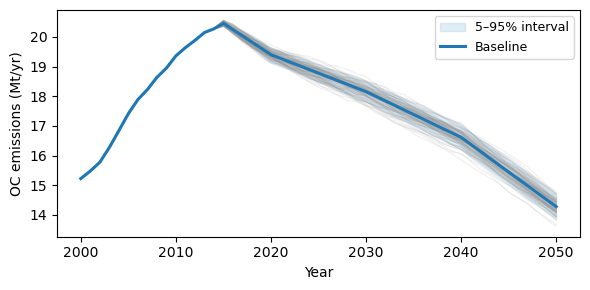

In [ ]:
plot_emission_ensemble(em_data, scenarios, gas="OC",    n_sample=100, save_name="OC_ensemble.pdf")

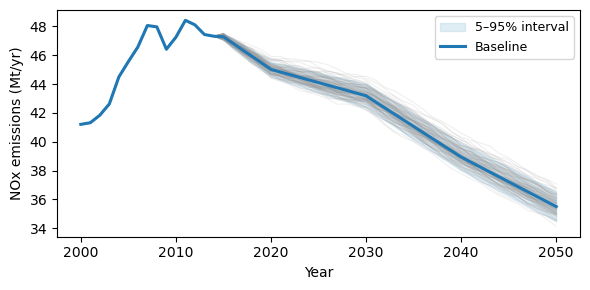

In [75]:
plot_emission_ensemble(em_data, scenarios, gas="NOx",   n_sample=100, save_name="NOx_ensemble.pdf")


## 4. Surrogate model training data format

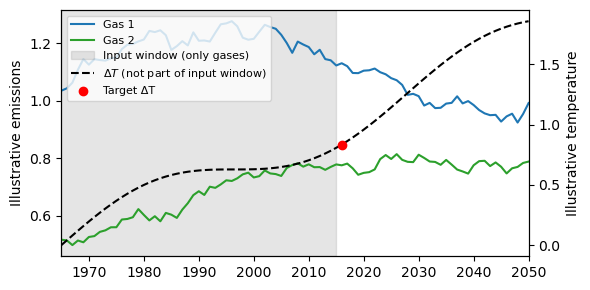

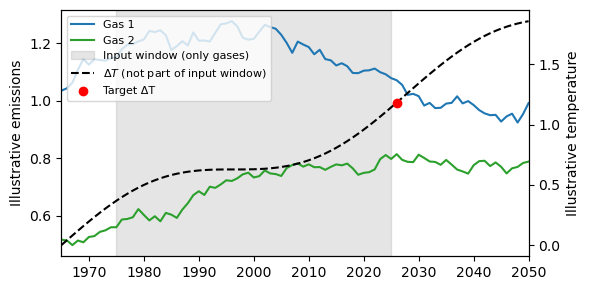

In [ ]:
# Function to plot schematic with clean style and updated legend
def plot_schematic(end_year, save_path):
    np.random.seed(0)
    years = np.arange(1965, 2051)
    n_years = len(years)
    
    # Simulated gas data
    gas1 = np.cumsum(np.random.randn(n_years)) * 0.02 + 1.0
    gas2 = np.cumsum(np.random.randn(n_years)) * 0.015 + 0.5
    temp = 0.02 * (years - 1965) + np.sin(0.1 * (years - 1965)) * 0.2  # base-like temperature
    
    start_window = end_year - 50
    mask_window = (years >= start_window) & (years <= end_year)
    
    fig, ax1 = plt.subplots(figsize=(6, 3))
    
    # Plot gases
    ax1.plot(years, gas1, label="Gas 1", color="tab:blue")
    ax1.plot(years, gas2, label="Gas 2", color="tab:green")
    
    # Highlight window
    ax1.axvspan(start_window, end_year, color="gray", alpha=0.2, label="Input window (only gases)")
    ax1.set_ylabel("Illustrative emissions")
    
    # Plot temperature on secondary axis
    ax2 = ax1.twinx()
    ax2.plot(years, temp, "--", color="black", label=r"$\Delta T$ (not part of input window)")
    ax2.set_ylabel("Illustrative temperature")
    
    # Mark target year
    target_year = end_year + 1
    target_temp = temp[years == target_year][0]
    ax2.scatter(target_year, target_temp, color="red", zorder=5, label="Target ΔT")
    
    # Legend combining both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left", fontsize=8)
    
    ax1.set_xlim(1965, 2050)
    plt.tight_layout()
    
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# Save updated versions
plot_schematic(2015, "plots/schematic_window_2015.pdf")
plot_schematic(2025, "plots/schematic_window_2025.pdf")